# Solving a Krichhoff plate blending problem with Morley element
Problem:
$$ \Delta^2 u = f \  in \ \Omega$$ 
$$  u = \frac{\partial u}{\partial \boldsymbol{n}} = 0 \ on \ \Gamma$$
note:
$$\Delta^{2} \equiv \nabla^{4}=\frac{\partial^{4}}{\partial x^{4}}+2 \frac{\partial^{4}}{\partial x^{2} \partial y^{2}}+\frac{\partial^{4}}{\partial y^{4}}$$
In this case, we consider $\Omega=(0,1) \times(0,1)$ and try
$$ 
f(x, y)=24\left[\left(x^{2}-x+1\right)^{2}+\left(y^{2}-y+1\right)^{2}+12\left(x^{2}-x\right)\left(y^{2}-y\right)\right]-40
$$
from 
$$
u(x, y)=x^{2}(1-x)^{2} y^{2}(1-y)^{2}
$$
We can write the problem as:
$$ \int_\Omega \boldsymbol{K}(u) : \boldsymbol{K}(v) \,\mathrm{d}x = \int_\Omega fv \,\mathrm{d}x \quad \forall v \in V $$

In [282]:
from skfem.models.poisson import unit_load
import numpy as np
from skfem.visuals.matplotlib import draw, plot
from skfem.utils import solver_iter_krylov, solver_eigen_scipy, solver_iter_pcg
from skfem.helpers import d, dd, ddot
from scipy.sparse.linalg import LinearOperator, minres
from skfem import *
from skfem.models.poisson import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.dpi'] = 200

## Assembling $K$ $f$ and storing boundary condition in `D`
mesh refined with m.refine(5)

In [283]:
m = MeshTri()
# m = MeshTri.init_symmetric()
m.refine(3)

e = ElementTriMorley()
ib = InteriorBasis(m, e)


@BilinearForm
def bilinf(u, v, w):
    return ddot(dd(u), dd(v))


@LinearForm
def mybih(v, w):
    x, y = w.x
    return (24 * ((x**2 - x + 1)**2 + (y**2 - y + 1)**2 + 12 * (x - 1) *
                  (y - 1) * x * y) - 40) * v


dofs = ib.find_dofs({
    'left': m.facets_satisfying(lambda x: x[0] == 0),
    'right': m.facets_satisfying(lambda x: x[0] == 1),
    'top': m.facets_satisfying(lambda x: x[1] == 1),
    'buttom': m.facets_satisfying(lambda x: x[1] == 0)
})

D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                    dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                    dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                    dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))

K = asm(bilinf, ib)
f = asm(mybih, ib)

## Solving $Ku = f$ using `pcg`

In [284]:
%%time
u = solve(*condense(K, f, D=D), solver=solver_iter_pcg()) 

Wall time: 5.58 ms


## Plotting results $\tilde{u}_{h}$

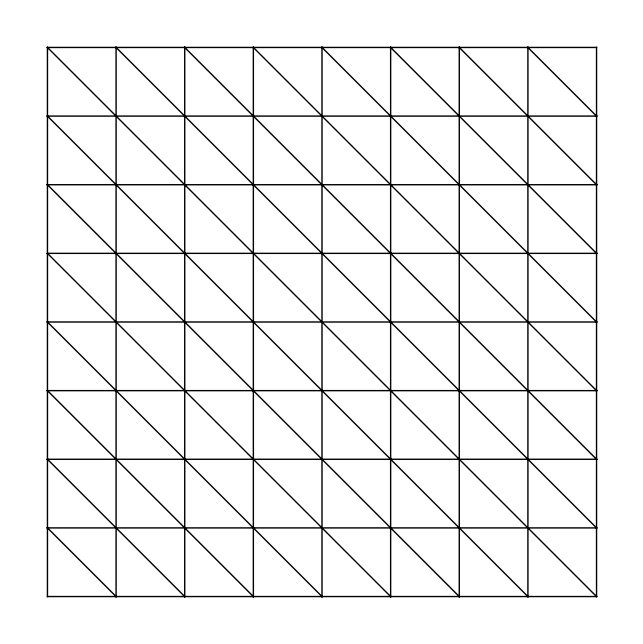

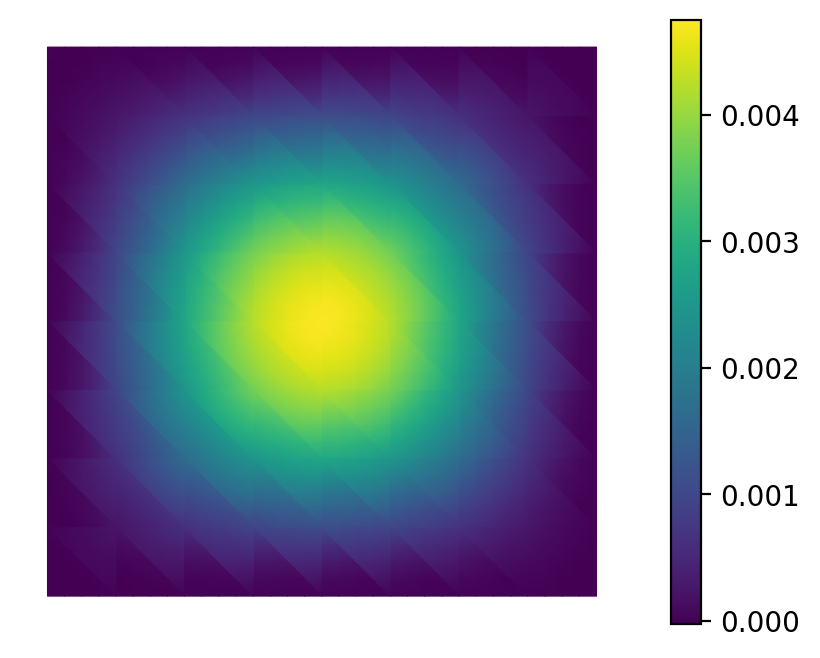

In [286]:
ax = draw(m)
# plot(ib, u, ax=ax, shading='gouraud', colorbar=True, Nrefs=2)
plot(ib, u, shading='gouraud', colorbar=True, Nrefs=2)
plt.show()

## Plotting original $u$

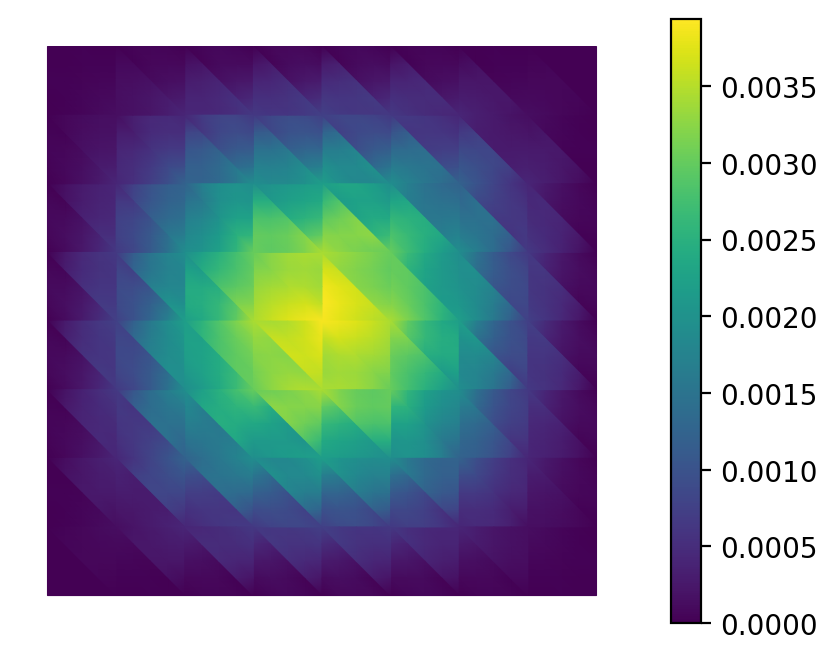

In [287]:
def orig(x, y):
    return (x * y * (1 - x) * (1 - y))**2


x = ib.doflocs[0]
y = ib.doflocs[1]
u_ori = orig(x, y)

plot(ib, u_ori, shading='gouraud', colorbar=True, Nrefs=2)
plt.show()

## Visualizing error


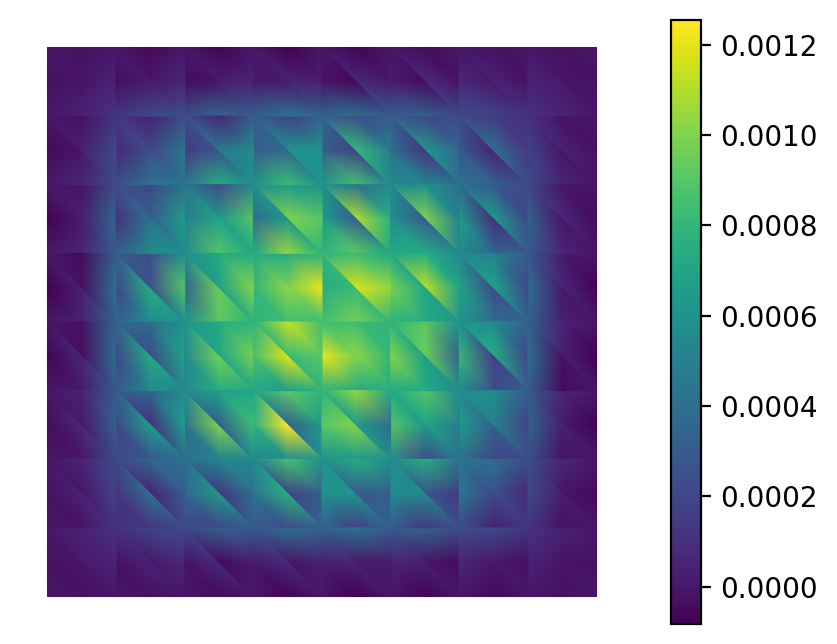

In [288]:
plot(ib, u-u_ori, shading='gouraud', colorbar=True)
plt.show()

## Convergence rate of $L2$ and $H1$ 

### Setting boundary and forms

In [296]:
def easy_boundary(basis):
    '''
    input basis
    ----------------
    return D for boundary conditions
    '''

    dofs = basis.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                        dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                        dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))
    return D


@BilinearForm
def bilinf(u, v, w):
    return ddot(dd(u), dd(v))


@LinearForm
def mybih(v, w):
    x, y = w.x
    return (24 * ((x**2 - x + 1)**2 + (y**2 - y + 1)**2 + 12 * (x - 1) *
                  (y - 1) * x * y) - 40) * v


def exact(x, y):
    return (x * y * (1 - x) * (1 - y))**2


def dexact(x, y):
    dux = (y * (1 - y))**2 * (4 * x**3 - 6 * x**2 + 2 * x)
    duy = (x * (1 - x))**2 * (4 * y**3 - 6 * y**2 + 2 * y)
    return dux, duy


@Functional
def L2Error(w):
    x, y = w.x
    return (w.w - exact(x, y))**2


def get_H1Error(basis, u):
    uh = basis.interpolate(u).value
    duh = basis.interpolate(u).grad
    dduh = ib.interpolate(u).hess
    x = basis.global_coordinates().value  # coordinates [x, y]
    dx = basis.dx
    dux, duy = dexact(x[0], x[1])
    return np.sqrt(np.sum(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx, axis=1)))

### Caculating

In [297]:
L2_list = []
H1_list = []
h_list = []
m = MeshTri()

pre_refine = 3
test_refine = 4

m.refine(pre_refine)

for i in range(test_refine):
    m.refine()

    e = ElementTriMorley()
    ib = InteriorBasis(m, e)

    K = asm(bilinf, ib)
    f = asm(mybih, ib)
    D = easy_boundary(ib)

    uh = solve(*condense(K, f, D=D), solver=solver_iter_pcg())

    U = ib.interpolate(uh).value

    L2 = np.sqrt(L2Error.assemble(ib, w=U))
    L2_list.append(L2)

    H1 = get_H1Error(ib, uh)
    H1_list.append(H1)

    h_list.append(m.param())
    print('case 2^-' + str(i + 1 + pre_refine))
    print('L2 Norm:', L2)
    print('H1 Norm:', H1)
    # print('hs', m.param())

case 2^-4
L2 Norm: 0.0001102063777379716
H1 Norm: 0.00035927480365417693
case 2^-5
L2 Norm: 2.795789222560985e-05
H1 Norm: 9.161174646200344e-05
case 2^-6
L2 Norm: 7.01656317785744e-06
H1 Norm: 2.3026845975110567e-05
case 2^-7
L2 Norm: 1.75586587479712e-06
H1 Norm: 5.764682368182897e-06


In [298]:
hs = np.array(h_list)
L2s = np.array(L2_list)
H1s = np.array(H1_list)
pfit_L2 = np.polyfit(np.log10(hs), np.log10(L2s), 1)
pfit_H1 = np.polyfit(np.log10(hs), np.log10(H1s + L2s), 1)
print('L2 convergence rate: ', pfit_L2[0])
print('H1 convergence rate: ', pfit_H1[0])

L2 convergence rate:  1.9910062924635865
H1 convergence rate:  1.9884987717077167


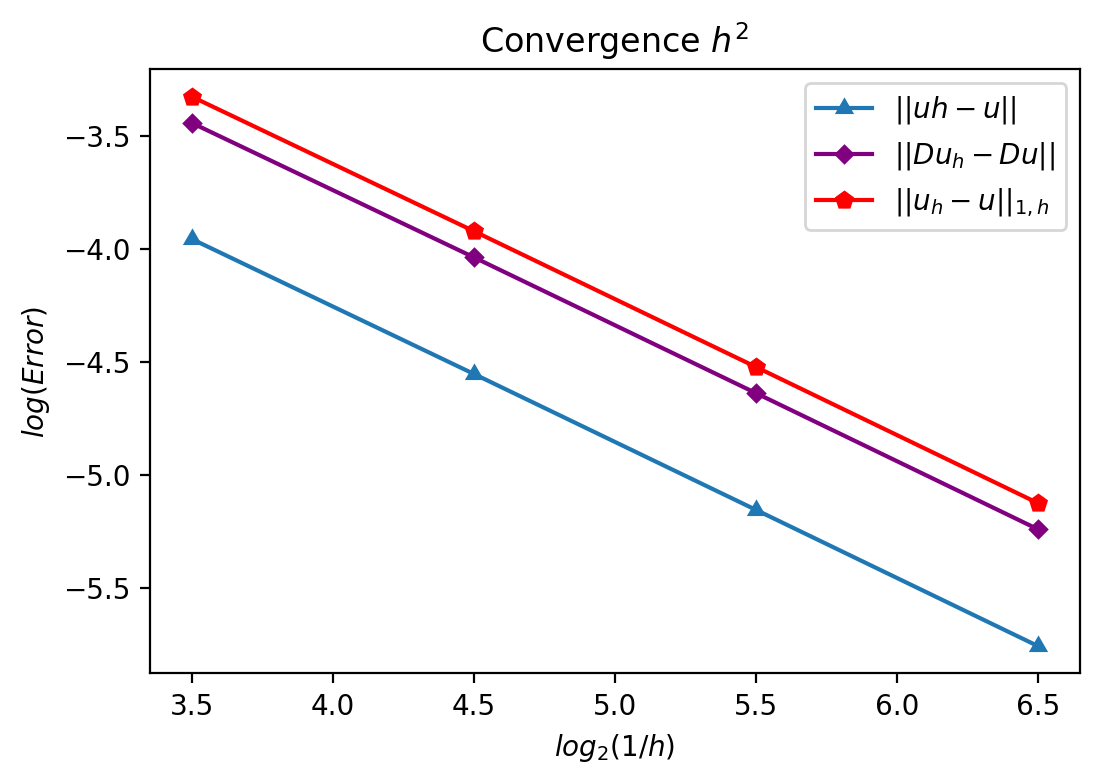

In [299]:
hs_Log = np.log2(hs)
L2s_log = np.log10(L2s)

L2plot, = plt.plot(-hs_Log, L2s_log, marker=(3, 0), label='$|\|uh-u\||}$')
H1s_log = np.log10(H1s)
Duplot, = plt.plot(-hs_Log,
                   H1s_log,
                   marker=(4, 0),
                   label=r'$|\left\|{Du}_{h}-Du\right\||$',
                   color='purple')
H1plot, = plt.plot(-hs_Log,
                   np.log10(L2s + H1s),
                   marker=(5, 0),
                   label=r'$|\left\|{u}_{h}-u\right\||_{1, h}$',
                   color='red')
plt.legend(handles=[L2plot, Duplot, H1plot])
plt.title('Convergence $h^{2}$')
plt.xlabel('$log_{2}(1/h)$')
plt.ylabel('$log(Error)$')
plt.show()